## Imports

In [216]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from scipy import stats
%matplotlib inline

label_encoder = preprocessing.LabelEncoder()

raw_dataset = pd.read_csv("data/raw_dataset.csv")

## Encodage

Nous avons dans notre jeu de données plusieurs colonnes qui ne contiennent pas des nombres mais du texte (`prenom`, `nom`), des dates (`date_creation_compte`), ou des catégories (`nationalite_frrançaise`, `region`, `niveau_etude`, `sexe`, `smoker`, `sport_licence`, `situation_familiale`).

Nos outils d'analyse et notre futur modèle ne peuvent pas fonctionner avec ces formats tels quels : nous devons d'abord encoder ces colonnes en associant à chaque possibilité une valeur numérique.

In [217]:
def etudes_to_number(x: str):
    if x == "aucun":
        return 0
    elif x == "bac":
        return 1
    elif x == "bac+2":
        return 2
    elif x == "master":
        return 3
    elif x == "doctorat":
        return 4
    else:
        return None


encoded_dataset = raw_dataset.copy()

encoded_dataset["prenom"] = label_encoder.fit_transform(encoded_dataset['prenom'])
encoded_dataset["nom"] = label_encoder.fit_transform(encoded_dataset['nom'])

encoded_dataset["niveau_etude"] = encoded_dataset.apply(lambda x: etudes_to_number(x["niveau_etude"]), axis=1)
encoded_dataset["date_creation_compte"] =  pd.to_datetime(encoded_dataset['date_creation_compte'])

# Auteres catégories
encoded_dataset = pd.get_dummies(encoded_dataset)

Nous allons également sauvegarder le dataset modifié à des fins d'archivage et de traçabilité.

In [218]:
encoded_dataset.to_csv('data/encoded_dataset.csv')

## Exploration des données

### Analyse statistique

In [219]:
encoded_dataset.describe()

,nom,prenom,age,taille,poids,niveau_etude,revenu_estime_mois,historique_credits,risque_personnel,date_creation_compte,score_credit,loyer_mensuel,montant_pret
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,4707.000000,10000.000000,10000,4694.000000,7094.00000,10000.000000
mean,520.834400,331.317700,46.516500,170.003760,70.064080,1.993400,2520.996200,2.543446,0.499094,2022-09-20 11:38:32.640000,573.495952,5175.89104,9149.762575
min,0.000000,0.000000,18.000000,119.200000,10.500000,0.000000,500.000000,0.000000,0.000000,2020-01-01 00:00:00,300.000000,-395.25000,500.000000
25%,285.000000,165.000000,32.000000,163.200000,59.800000,1.000000,1683.000000,1.000000,0.240000,2021-05-12 00:00:00,437.000000,985.76750,500.000000
50%,521.000000,330.000000,46.000000,170.100000,70.200000,2.000000,2480.000000,3.000000,0.500000,2022-09-25 00:00:00,574.000000,5000.00000,3600.605667
75%,777.000000,489.000000,61.000000,176.800000,80.300000,3.000000,3304.000000,4.000000,0.750000,2024-01-30 00:00:00,712.000000,10000.00000,16245.534725
max,987.000000,657.000000,75.000000,209.800000,145.200000,4.000000,6826.000000,5.000000,1.000000,2025-06-09 00:00:00,849.000000,10000.00000,53192.053509
std,286.479098,187.903109,16.832845,10.006542,15.014911,1.421464,1157.532502,1.691198,0.290107,NaN,159.140639,3750.61004,10785.937404


### Corrélations

<Axes: >

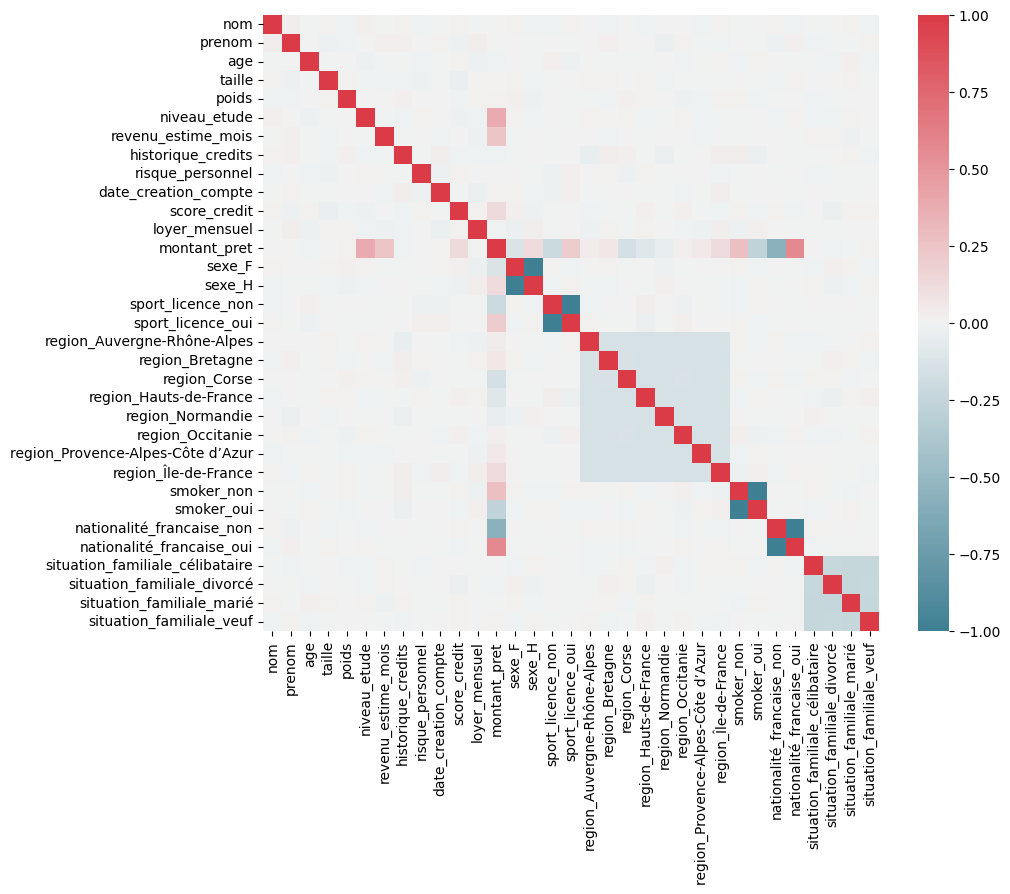

In [220]:
f, ax = plt.subplots(figsize=(10, 8))
corr = encoded_dataset.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax
)

Nous observons ici que la colonne `montant_pret` est particulièrement corrélée aux colonnes `score_credit`, `revenu_estime_mois`, `nationalite_française`, `smoker`, `region`, `niveau_etude`, `sport_licence`, et `sexe`.

Nous pouvons d'ailleurs constater que notre jeu de données favorise très fortement les individus de nationalité française, et défavorise fortement les autres. Il s'agit même du critère principal déterminant le montant final du prêt. Afin de ne pas produire un modèle discriminatoire et illégal, nous devrons retirer cette notion après le nettoyage du *dataset*.

### Données aberrantes

<Axes: >

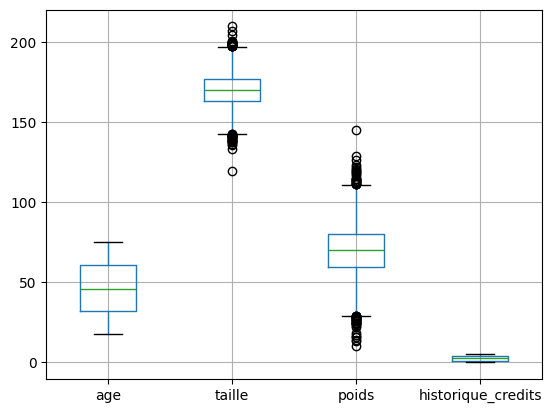

In [221]:
encoded_dataset.boxplot(column = ["age", "taille", "poids", "historique_credits"])

<Axes: >

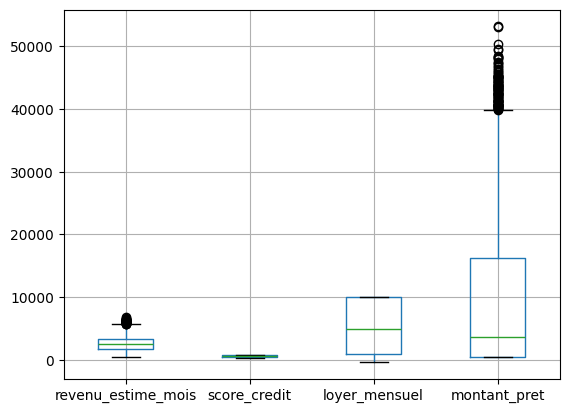

In [222]:
encoded_dataset.boxplot(column = ["revenu_estime_mois", "score_credit", "loyer_mensuel", "montant_pret"])

### Données manquantes

<Axes: >

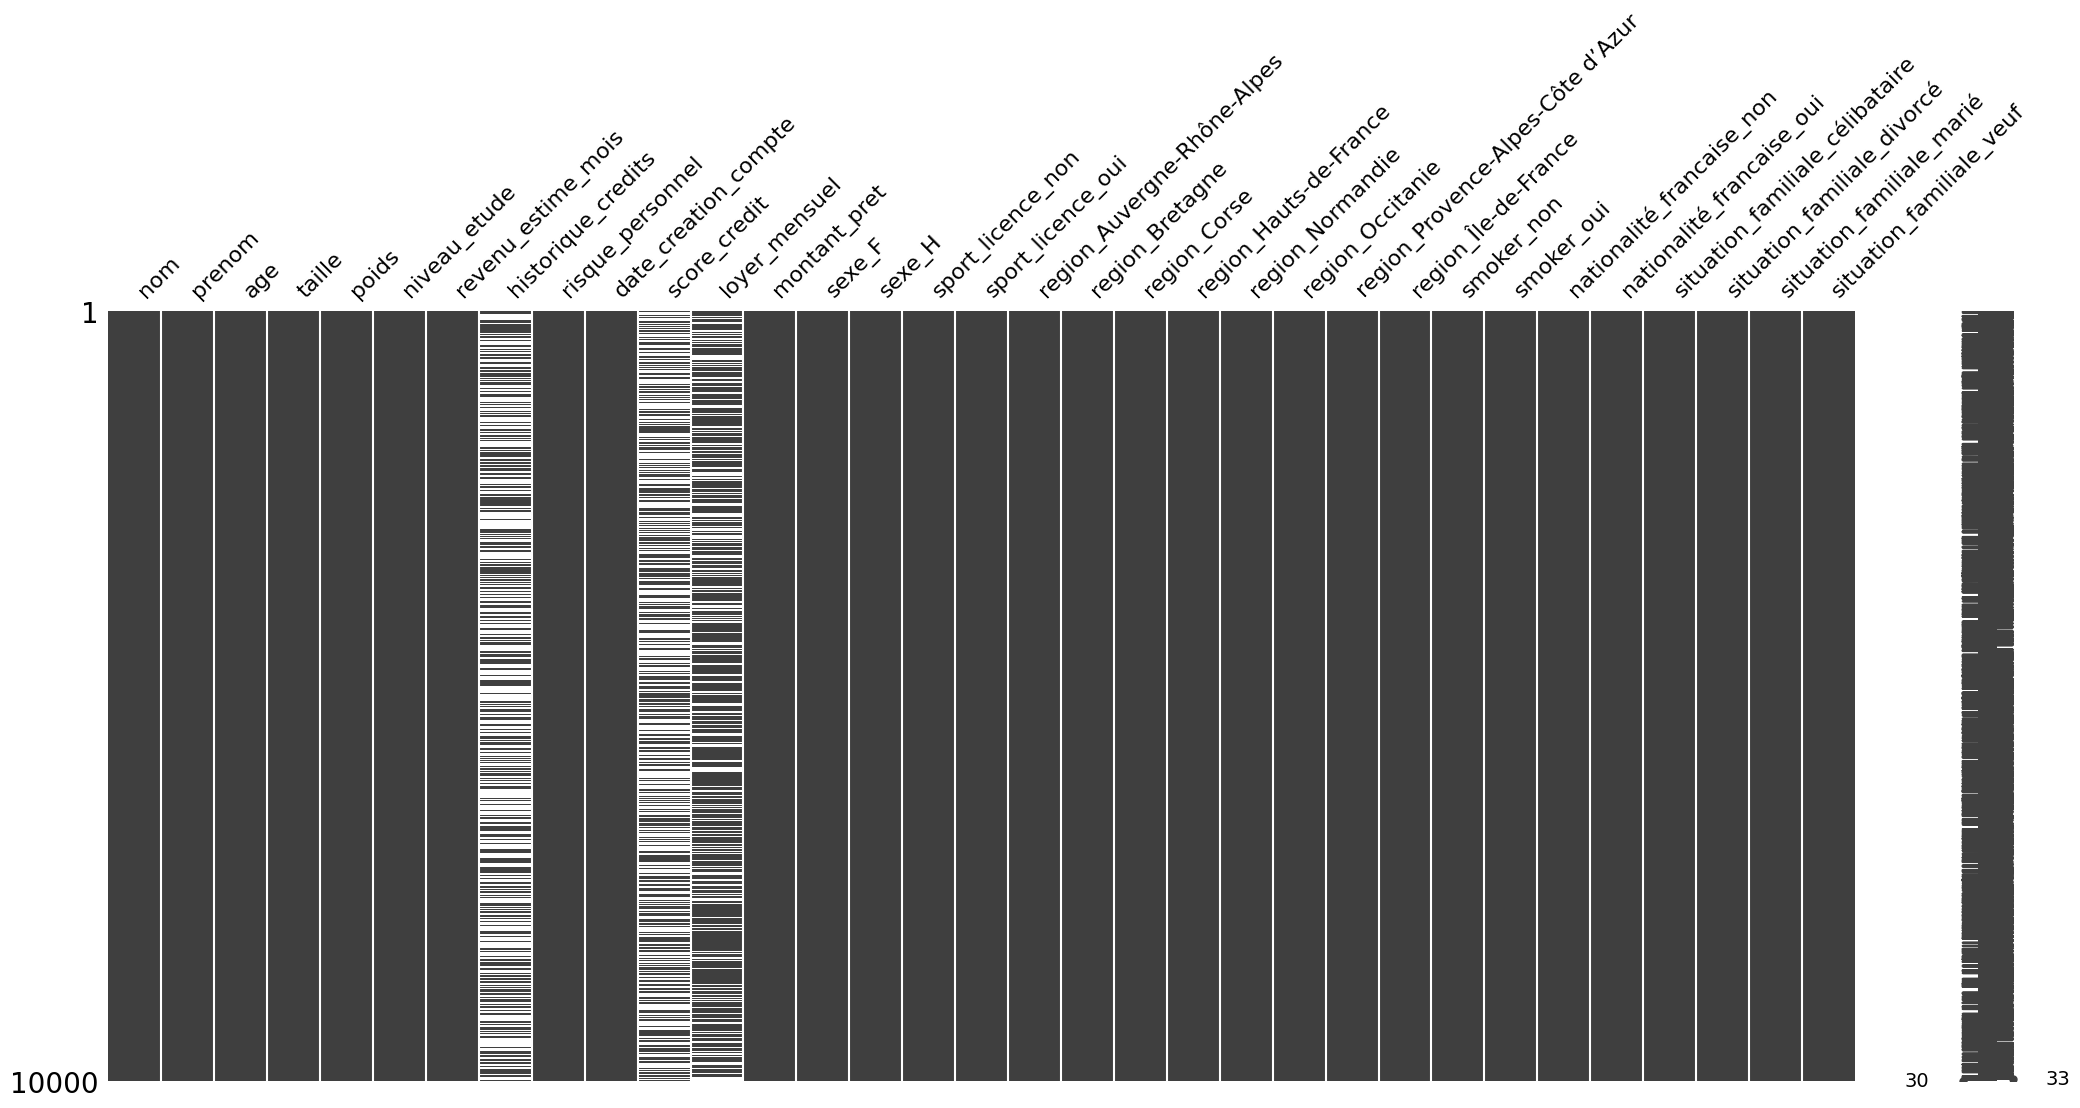

In [223]:
msno.matrix(encoded_dataset)

<Axes: >

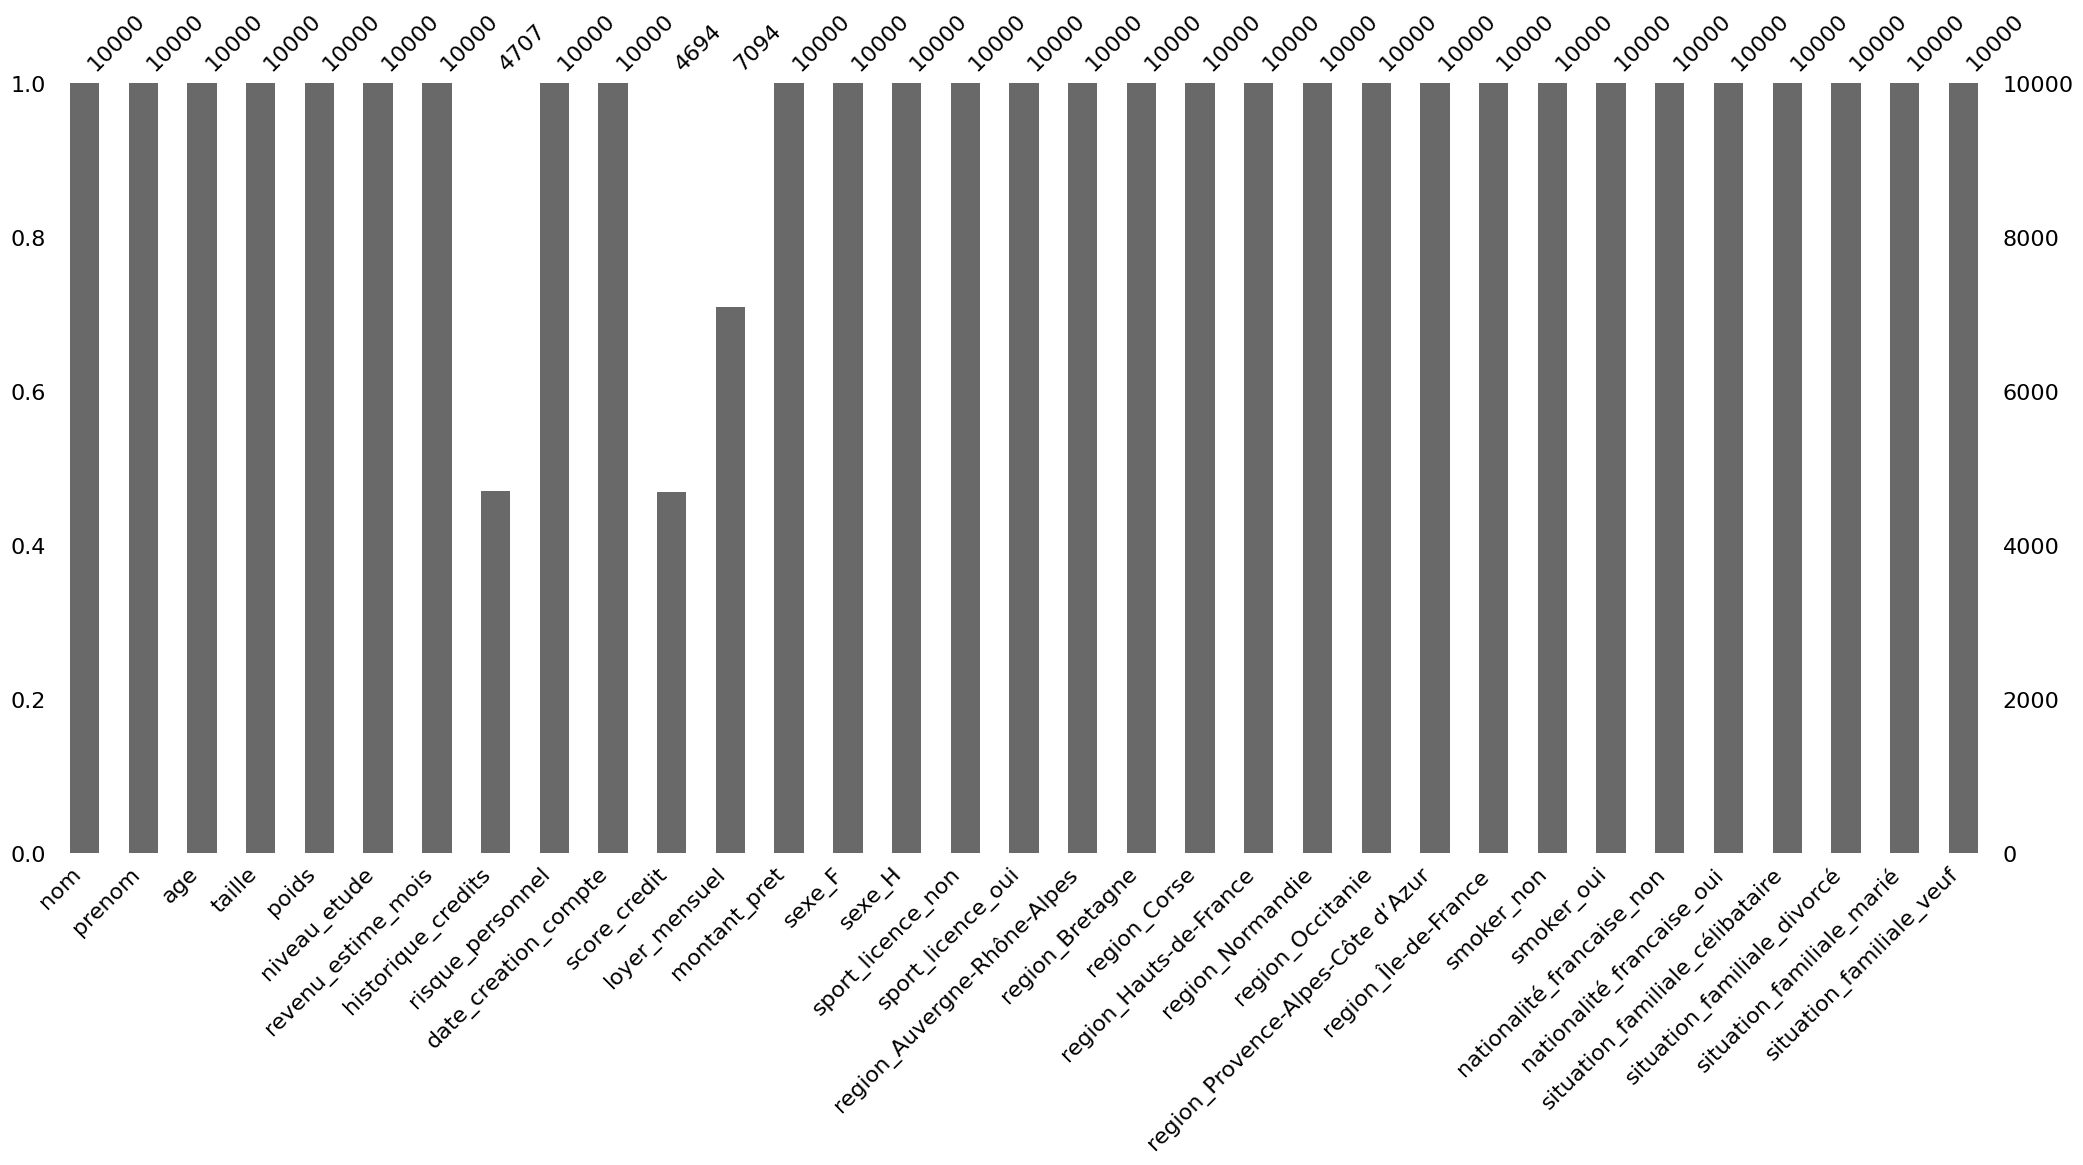

In [224]:
msno.bar(encoded_dataset)

Nous pouvons voir que certaines lignes ne possèdent pas de valeurs définies pour les colonnes `situation_familliale`, `historique_credits`, `score_credit`, `loyer_mensuel`.

## Nettoyage du jeu de données

### Suppression des doublons

In [225]:
cleaned_dataset = encoded_dataset.drop_duplicates(inplace=False)

### Gestion des valeurs indéfinies

Nous avons vu que pour certaines lignes du corpus, les colonnes `historique_credits`, `score_credit`, et `loyer_mensuel` ne sont pas remplies.

Nous allons interpoler les valeurs manquantes à partir de la médiane de chaque colonne.

In [226]:
cleaned_dataset = cleaned_dataset.fillna(value=cleaned_dataset.median(), inplace=False) 

### Suppression des erreurs de saisie

Nous avons au sein du *dataset* des valeurs négatives dans la colonne `loyer_mensuel`.

La notion de "loyer négatif" n'ayant pas de sens, nous allons présumer qu'il s'agit d'erreurs de saisies et supprimer les lignes concernées.

In [227]:
cleaned_dataset = cleaned_dataset.drop(cleaned_dataset.loc[cleaned_dataset["loyer_mensuel"] < 0.0].index, inplace=False)

### Suppression des valeur aberrantes

In [228]:
threshold = 1.5

def find_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    outliers = cleaned_dataset[(col < Q1 - threshold * IQR) | (col > Q3 + threshold * IQR)]
    return outliers

poids_outliers = find_outliers(cleaned_dataset["poids"])
cleaned_dataset = cleaned_dataset.drop(poids_outliers.index)

taille_outliers = find_outliers(cleaned_dataset["taille"])
cleaned_dataset = cleaned_dataset.drop(taille_outliers.index)

revenu_outliers = find_outliers(cleaned_dataset["revenu_estime_mois"])
cleaned_dataset = cleaned_dataset.drop(revenu_outliers.index)

pret_outliers = find_outliers(cleaned_dataset["montant_pret"])
cleaned_dataset = cleaned_dataset.drop(pret_outliers.index)

## Analyse statistique du dataset nettoyé

In [229]:
cleaned_dataset.describe()

,nom,prenom,age,taille,poids,niveau_etude,revenu_estime_mois,historique_credits,risque_personnel,date_creation_compte,score_credit,loyer_mensuel,montant_pret
count,9733.000000,9733.000000,9733.000000,9733.000000,9733.000000,9733.000000,9733.000000,9733.000000,9733.000000,9733,9733.000000,9733.000000,9733.000000
mean,521.016850,330.967533,46.558821,170.005415,70.112031,1.975342,2498.129251,2.784034,0.498693,2022-09-18 21:02:36.457412864,573.144765,5135.434634,8750.521112
min,0.000000,0.000000,18.000000,142.800000,29.200000,0.000000,500.000000,0.000000,0.000000,2020-01-01 00:00:00,300.000000,8.510000,500.000000
25%,285.000000,165.000000,32.000000,163.200000,59.900000,1.000000,1672.000000,3.000000,0.240000,2021-05-11 00:00:00,574.000000,5000.000000,500.000000
50%,521.000000,330.000000,46.000000,170.100000,70.200000,2.000000,2467.000000,3.000000,0.500000,2022-09-24 00:00:00,574.000000,5000.000000,3282.616971
75%,778.000000,489.000000,61.000000,176.800000,80.300000,3.000000,3276.000000,3.000000,0.750000,2024-01-28 00:00:00,574.000000,5000.000000,15711.870033
max,987.000000,657.000000,75.000000,197.000000,110.800000,4.000000,5736.000000,5.000000,1.000000,2025-06-09 00:00:00,849.000000,10000.000000,39623.805852
std,286.686511,188.151161,16.825101,9.784589,14.610846,1.416685,1133.253423,1.185092,0.290434,NaN,108.859875,3155.739456,10212.028555


<Axes: >

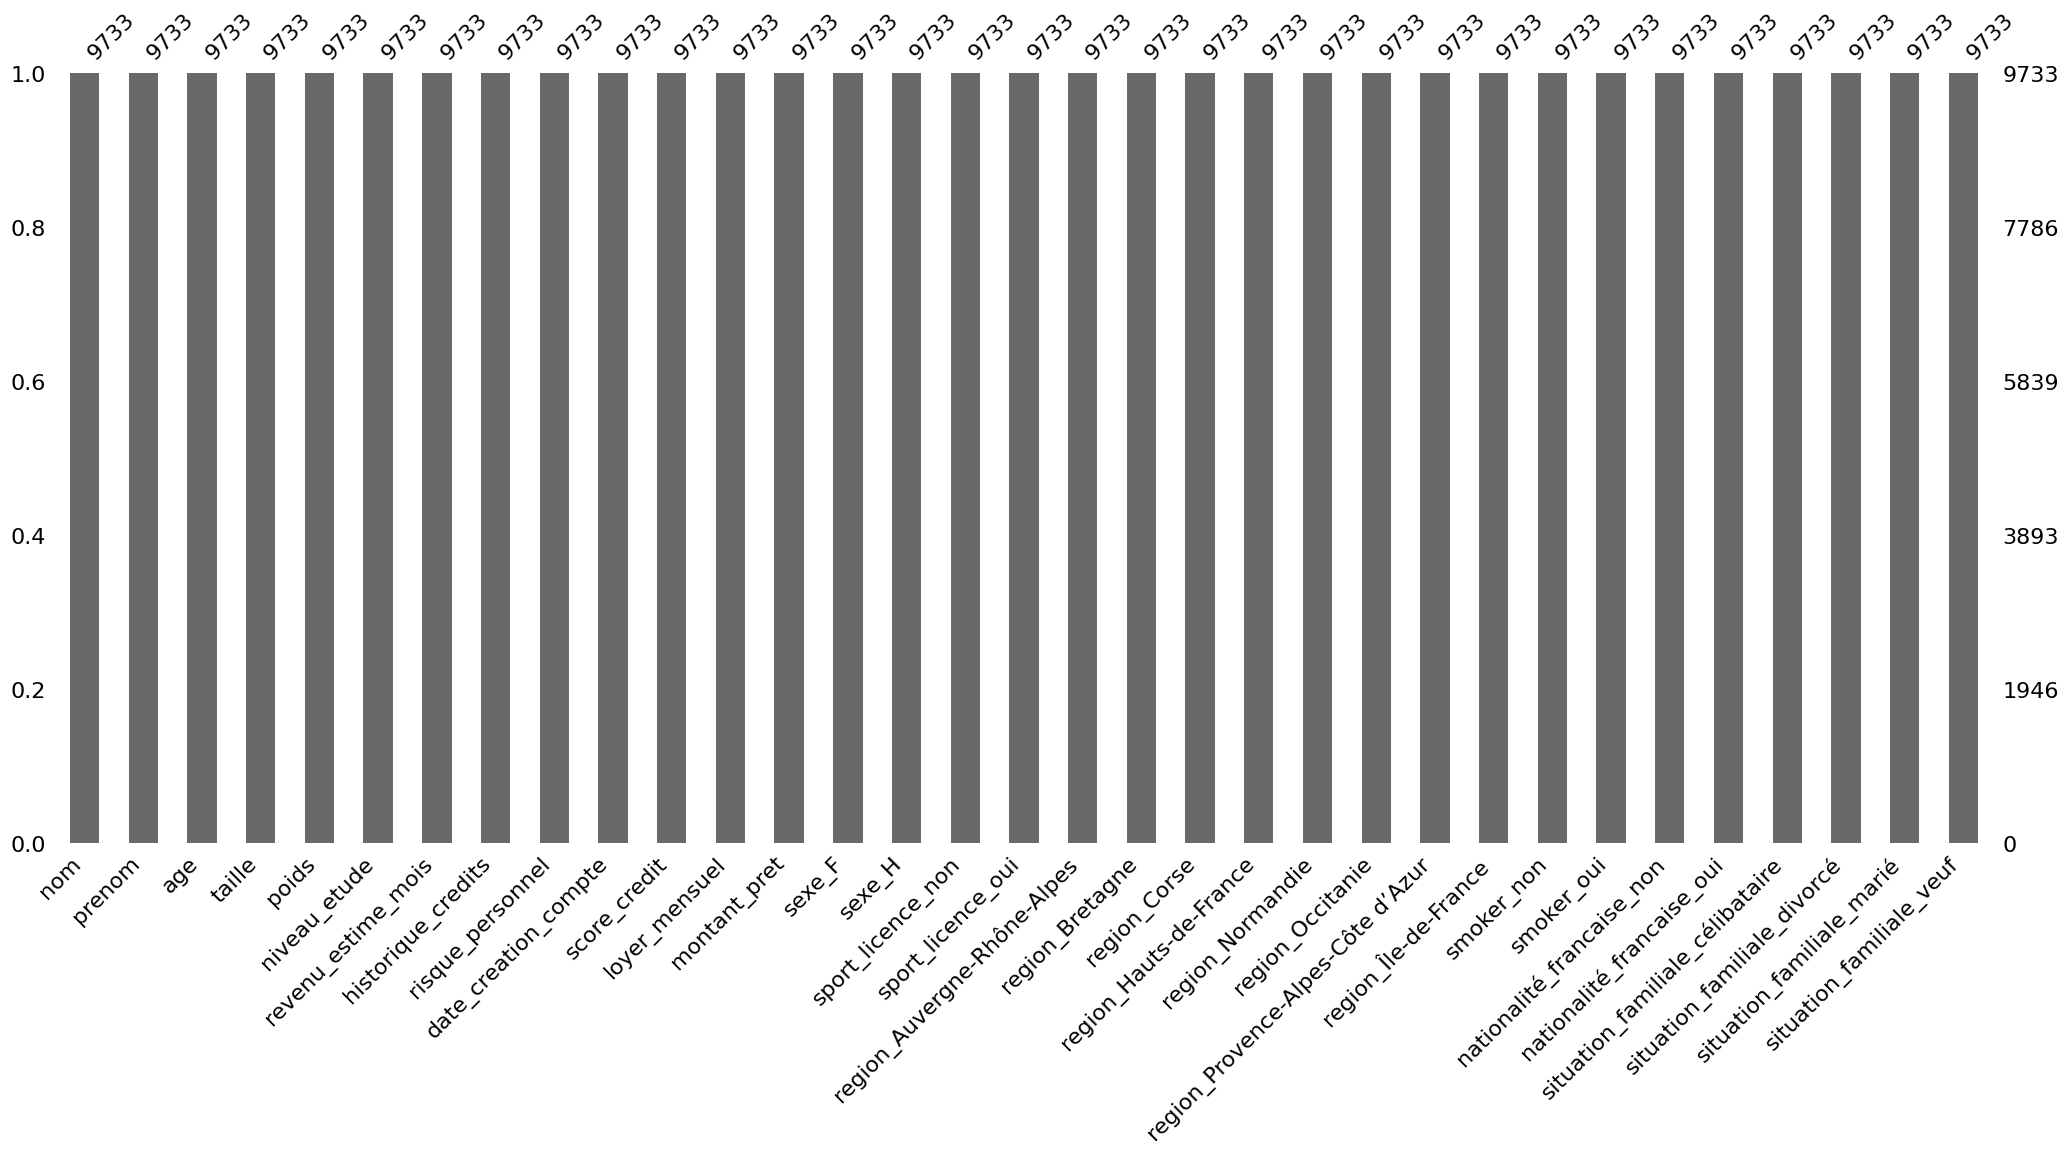

In [230]:
msno.bar(cleaned_dataset)

<Axes: >

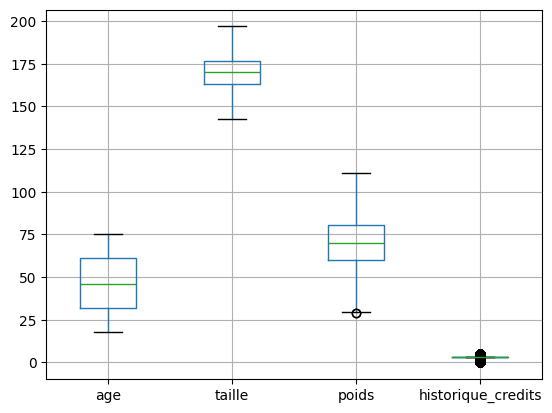

In [231]:
cleaned_dataset.boxplot(column = ["age", "taille", "poids", "historique_credits"])

<Axes: >

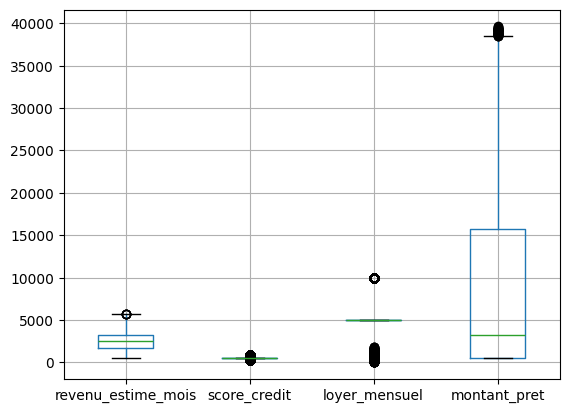

In [232]:
cleaned_dataset.boxplot(column = ["revenu_estime_mois", "score_credit", "loyer_mensuel", "montant_pret"])

## Sauvegarde du jeu de données nettoyé

In [233]:
cleaned_dataset.to_csv('data/cleaned_dataset.csv')

## Analyse éthique

Maintenant que nous avons nettoyé notre *dataset*, nous allons examiner quelles colonnes devraient être supprimées pour avoir un modèle éthique et respecter la loi.

### Évaluation de la pertinence des colonnes

- `nom` et `prenom` : données purement personnelles qui ne sont pas censées avoir d'impact sur le montant final du prêt. Ces colonnes pourraient rendre le modèle sensible aux attaques (un acteur mal intentionné pourrait récupérer le montant d'un prêt réalisé par une certaine personne dans le dataset d'entraînement) et biaisé envers certains noms ou prénoms. Il serait préférable de les retirer du corpus.
- `age` : ne pose pas de problème particulier, et doit être pris en compte.
- `taille` et `poids` : données pouvant être utiles pour estimer l'état de santé de l'emprunteur. Seulement, l'une n'est pas pertinente sans l'autre (le poids idéal varie en fonction de la taille) et il est difficile de savoir comment le modèle va interpréter ces données (d'autant plus que nous ne savons pas exactement comment les banquiers ont pris leurs décisions dans les données que nous avons). Il semble préférable de remplacer ces colonnes par une seule colonne `IMC` afin d'éviter tout risque de biais de la part de notre modèle.
- `sexe`, `region`, `nationalite_française` : ces données ne devraient pas avoir d'influence sur le montant final du prêt, et pourraient créer des comportements discriminatoires chez notre modèle. Il est sûrement préférable de les retirer.
- `sport_licence`, `smoker` : données pertinentes vis-à-vis de la santé de l'emprunteur et donc du risque qu'il représente. Données catégorielles (catégories : oui ou non)
- `niveau_etude`, `revenu_estime_mois`, `loyer_mensuel` : données pertinentes vis-à-vis de la capacité de remboursement de l'emprunteur.
- `historique_credits`, `risque_personnel`, `date_creation_compte`, `score_credit` : données pertinentes.
- `situation familiale` : Cette donnée pourrait indiquer une certaine capacité de remboursement de l'emprunteur, mais rien ne permet d'affirmer ici que tous les prêts contractés par des individus mariés concernent les deux époux.

### Mise en conformité

Afin de minimiser le nombre de données personnelles dans le dataset (comme l'exige le RGPD), d'anonymiser ces données, et d'éviter tout comportement potentiellement discriminatoire de notre modèle, nous allons retirer les colonnes `nom`, `prenom`, `sexe`, `region`, `nationalie_francaise`, `taille`, `poids`, peu importe leur niveau de corrélation avec le résulta final.

In [234]:
final_dataset = cleaned_dataset.copy()

final_dataset["imc"] = final_dataset.apply(lambda x: x["poids"] / ((x["taille"] / 100) ** 2), axis=1)

final_dataset = final_dataset.drop(columns=["nom", "prenom", "sexe_H", "sexe_F", "nationalité_francaise_oui", "nationalité_francaise_non", "taille", "poids"])
final_dataset = final_dataset[final_dataset.columns.drop(list(final_dataset.filter(regex='region_')))]


<Axes: >

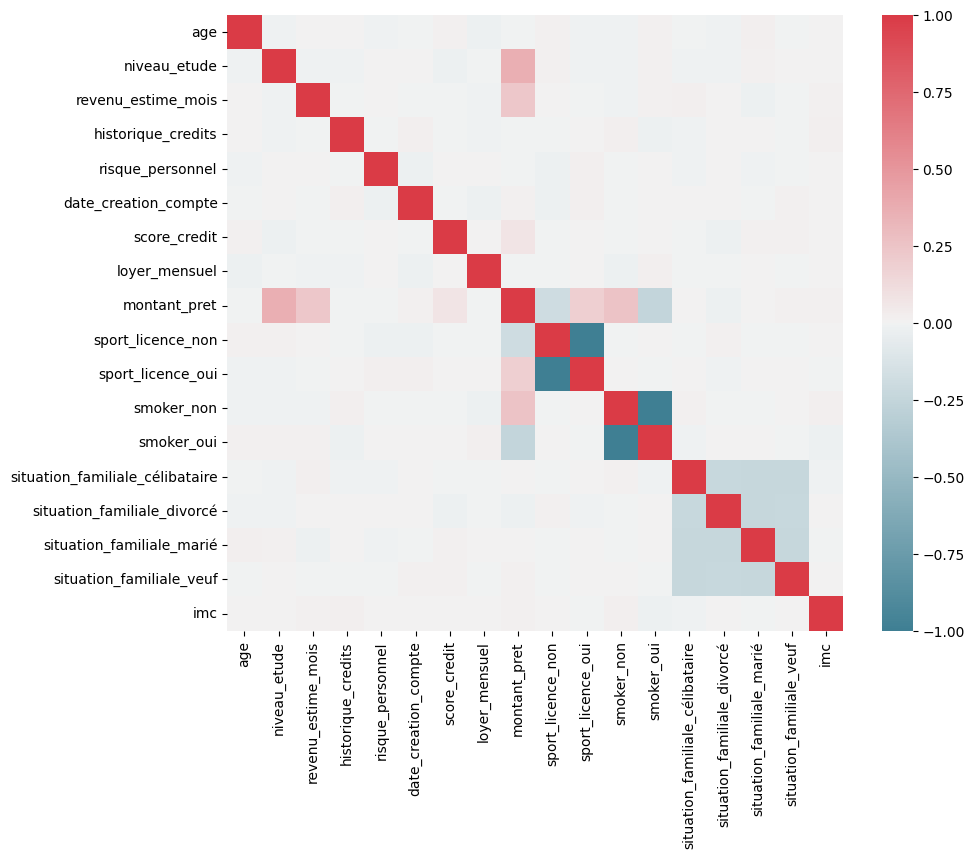

In [235]:
f, ax = plt.subplots(figsize=(10, 8))
corr = final_dataset.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax
)

### Sauvegarde du jeu de données conforme

In [236]:
final_dataset.to_csv('data/final_dataset.csv')